# Import libraries

In [2]:
!pip3 install pydicom
!pip3 install keras
!pip3 install tensorflow
!pip3 install sklearn
!pip3 install segmentation_models
!pip3 install generic_utils

!pip3 install  albumentations
!pip3 install backbone-network

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1569094745522622064, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15703311680
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9266874624666423876
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import cv2
import csv
import pickle
import pydicom
import numpy as np
import pandas as pd 
from glob import glob
import gc
import keras
import tensorflow as tf
from keras import backend as K

from iou_dice_loss_functions import my_iou_metric, bce_dice_loss
%env SM_FRAMEWORK=tf.keras

from data_generator_functions import data_generator
import seg_models
keras.backend.set_image_data_format('channels_last')

from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

seed = 1994
np.random.seed = seed
os.environ['PYTHONHASHSEED'] = str(seed)
tf.seed = seed

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
Segmentation Models: using `tf.keras` framework.


# Dataset

In [6]:
# defining configuration parameters
org_size = 1024 # original image size
img_size = 256 # image resize size
batch_size = 40 # batch size for training unet

## Load train and validation data from files

In [7]:
pkl_file_train = open('process_data/X_train.pkl', 'rb')

X_train = pickle.load(pkl_file_train)
print(X_train)

['../Dataset/stage1_sim/1.2.276.0.7230010.3.1.4.8323329.1702.1517875169.44421.dcm'
 '../Dataset/stage1_sim/1.2.276.0.7230010.3.1.4.8323329.5196.1517875186.906815.dcm'
 '../Dataset/stage1_sim/1.2.276.0.7230010.3.1.4.8323329.2310.1517875172.88826.dcm'
 ...
 '../Dataset/stage1_sim/1.2.276.0.7230010.3.1.4.8323329.6776.1517875201.61444.dcm'
 '../Dataset/stage1_sim/1.2.276.0.7230010.3.1.4.8323329.2039.1517875170.835799.dcm'
 '../Dataset/stage1_sim/1.2.276.0.7230010.3.1.4.8323329.10187.1517875222.531834.dcm']


In [8]:
pkl_file_val = open('process_data/X_val.pkl', 'rb')

X_val = pickle.load(pkl_file_val)

In [9]:
pkl_file_masks = open('process_data/masks.pkl', 'rb')

masks = pickle.load(pkl_file_masks)

## Data generation & Augmentations

In [10]:
import albumentations as A

In [11]:
training_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
         ], p=0.3),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20,
                                        interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, p=1),
    A.RandomSizedCrop(min_max_height=(206,256), height=img_size, width=img_size,p=0.25)
],p=1)

In [12]:
params_train = {'img_size': img_size,
          'batch_size': batch_size,
          'n_channels': 3,
          'shuffle': True,
           'augmentations':training_augmentation,
           }

params_val = {'img_size': img_size,
          'batch_size': batch_size,
          'n_channels': 3,
          'shuffle': True,
         }

# Generators
training_generator = data_generator(X_train, masks, **params_train)
validation_generator = data_generator(X_val, masks, **params_val)

In [13]:
x, y = training_generator.__getitem__(0)
print(x.shape, y.shape)

(40, 256, 256, 3) (40, 256, 256, 1)


# Segmentation model

In [14]:
K.clear_session()

In [15]:
BACKBONE = 'resnet34'
model = seg_models.Unet(backbone_name=BACKBONE, encoder_weights='imagenet') #, decoder_use_batchnorm=False)
model.summary()

85524480/85521592 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

In [16]:
opt = SGD(momentum=0.9)

In [17]:
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[my_iou_metric])

In [18]:
from swa import SWA
from annealing_scheduler_function import CosineAnnealingScheduler

In [19]:
epochs = 60
swa = SWA('model_output/256_resnet34_swa_stage1_exp4.model',55)

callbacks = [
    ModelCheckpoint("model_output/256_resnet34_stage1_exp4.model",monitor='val_loss', 
                            mode = 'min', save_best_only=True,
                            verbose=1),
    swa,
    CosineAnnealingScheduler(T_max=epochs, eta_max=1e-3, eta_min=1e-5, verbose=1)
]

In [20]:
history = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,   
                           epochs=epochs, verbose=1,
                            callbacks=callbacks)

Stochastic weight averaging selected for last 5 epochs.
Epoch 1/60

Epoch 00001: CosineAnnealingScheduler setting learning rate to 0.001.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
224/224 [==============================] - 3898s 17s/step - loss: 1.2659 - my_iou_metric: 0.3152 - val_loss: 1.0658 - val_my_iou_metric: 0.8040

Epoch 00001: val_loss improved from inf to 1

dict_keys(['loss', 'my_iou_metric', 'val_loss', 'val_my_iou_metric', 'lr'])


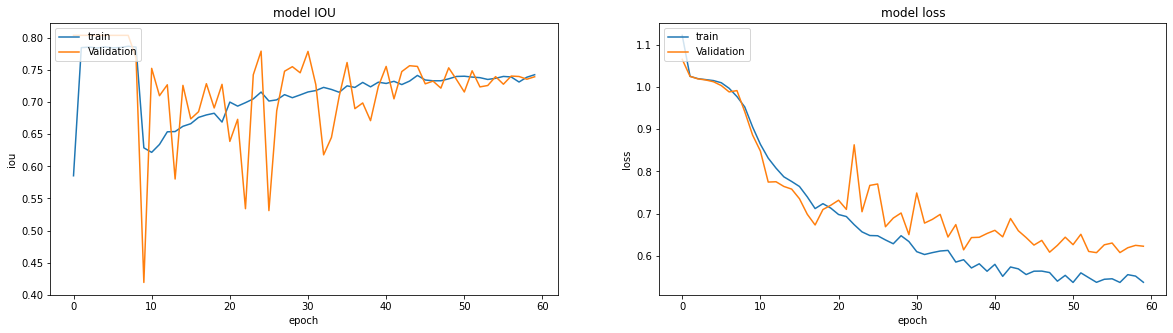

In [21]:
# list all data in history
import matplotlib.pyplot as plt
 
print(history.history.keys())

# summarize history for iou
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['my_iou_metric'])
plt.plot(history.history['val_my_iou_metric'])
plt.title('model IOU')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')